## Projeto Final:

### Bibliotecas

In [257]:
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
from plyer import notification 
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns 

### Alerta

In [8]:
def alerta(nivel, base, etapa, erro=""):
    '''
        #!pip install plyer
        Alerta de falha de carregamento de base de dados
    '''
    now = str(datetime.now())

    msg = f"Falha no carregamento da base {base} na etapa {etapa}.\n{now}\n{erro}"


    if nivel == 1:
        title = 'ATENÇÃO: Alerta Baixo'
    elif nivel == 2:
        title = 'ATENÇÃO: Alerta Médio'
    elif nivel  == 3:
        title = 'ATENÇÃO: Alerta Alto'
    else:
        print("Nivel",nivel,"não disponível!")

    notification.notify(
            title=title,
            message=msg,
            app_name='alerta',
            timeout=10
        )


### 1 Chamada de API

In [13]:
def chamada_API(url):
    response = requests.get(url, verify=False)
    
    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame(data)
    else:
        alerta(1, f"Acesso a API, erro = {response.status_code}",'')
        return response.status_code
        
    

##### 1.1 Bancos

In [14]:
bancos = chamada_API('https://brasilapi.com.br/api/banks/v1')
bancos.head(5)

c:\Users\A0045759\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'brasilapi.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,ispb,name,code,fullName
0,00000000,BCO DO BRASIL S.A.,1.0,Banco do Brasil S.A.
1,00000208,BRB - BCO DE BRASILIA S.A.,70.0,BRB - BANCO DE BRASILIA S.A.
2,00038121,Selic,NaN,Banco Central do Brasil - Selic
3,00038166,Bacen,NaN,Banco Central do Brasil
4,00122327,SANTINVEST S.A. - CFI,539.0,"SANTINVEST S.A. - CREDITO, FINANCIAMENTO E INV..."


##### 1.2 Taxas

In [15]:
taxas = chamada_API('https://brasilapi.com.br/api/taxas/v1')
taxas

c:\Users\A0045759\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'brasilapi.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,nome,valor
0,Selic,10.50
1,CDI,10.40
2,IPCA,3.93


##### 1.3: PIX

In [59]:
pix = chamada_API('https://brasilapi.com.br/api/pix/v1/participants')
pix.tail()

c:\Users\A0045759\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'brasilapi.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,ispb,nome,nome_reduzido,modalidade_participacao,tipo_participacao,inicio_operacao
821,95213211,"COOPERATIVA DE CRéDITO, POUPANçA E INVESTIMENT...",COOP SICREDI CAMINHO DAS ÁGUAS RS,PDCT,IDRT,2020-11-03T09:30:00.000Z
822,95424891,"COOPERATIVA DE CRÉDITO, POUPANÇA E INVESTIMENT...",COOP SICREDI VALE DO RIO PARDO,PDCT,IDRT,2020-11-03T09:30:00.000Z
823,95594941,"COOPERATIVA DE CRÉDITO, POUPANÇA E INVESTIMENT...",COOP SICREDI REG CENTRO RS/MG,PDCT,IDRT,2020-11-03T09:30:00.000Z
824,97259253,COOPERATIVA E ECONOMIA E CRÉDITO MÚTUO DOS MÉD...,CECM MÉDICOS PLANALTO MÉDIO RS - CREDISIS/CRED...,PDCT,IDRT,2021-10-04T12:53:10.567Z
825,97489280,"COOPERATIVA DE CRÉDITO, POUPANÇA E INVESTIMENT...",COOP SICREDI INTEGRAÇÃO BAHIA,PDCT,IDRT,2020-11-03T09:30:00.000Z


In [43]:
bancos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ispb      359 non-null    object 
 1   name      357 non-null    object 
 2   code      348 non-null    float64
 3   fullName  357 non-null    object 
dtypes: float64(1), object(3)
memory usage: 11.3+ KB


### 3 Banco de Dados

In [21]:
def tabelas_bd():
    '''
        Retorna um dataframe com as tabelas do banco de dados.
    '''
    conn = sqlite3.connect('coderhouse.db')

    # Executar uma consulta que retorna as informações do esquema do banco de dados
    query = "SELECT name FROM sqlite_master WHERE type='table'"
    schema = pd.read_sql_query(query, conn)

    conn.close()

    return schema
def salva_bd(df, nome_tabela):
    '''
        Salva dataframe df na tabela nome_tabela.
    '''
    conn = sqlite3.connect('coderhouse.db')

    # Escrever o DataFrame na tabela 'nome_tabela'
    df.to_sql(nome_tabela, conn, if_exists='replace', index=False)

    conn.close()

    return True
def carrega_bd(nome_tabela):
    '''
        Carrega tabela nome_tabela num dataframe. 
    '''
    conn = sqlite3.connect('coderhouse.db')

    # Executar uma consulta SELECT na tabela 'produtos' e converter em um DataFrame
    query = f"SELECT * FROM {nome_tabela}"
    df = pd.read_sql(query, conn)

    conn.close()

    return df

##### 3.1 Salvando tabelas no banco de dados

In [190]:
salva_bd(bancos,"bancos")
salva_bd(pix,"pix")
salva_bd(taxas,"taxa")

True

### 4 Transformação
##### 4.1 Bancos

In [192]:
def transformacao_bancos():
    
    try:
        #Bancos
        df_bancos = carrega_bd("bancos")
        df_bancos['name']       = df_bancos['name'].fillna('ND')
        df_bancos['fullName']   = df_bancos['fullName'].fillna('ND')
        df_bancos['code']       = df_bancos['code'].fillna(0)
        df_bancos['name']       = df_bancos['name'].str.upper()
        df_bancos['fullName']       = df_bancos['fullName'].str.upper()
        
        salva_bd(df_bancos,"bancos")
        print("bancos salvo")
        
    except Exception as e:
        alerta(nivel = 2, 
               base = "bancos", 
               etapa = "TRANSFORMACAO", 
               erro=e)
        

In [191]:
transformacao_bancos()

bancos salvo


In [193]:
carrega_bd("bancos")

,ispb,name,code,fullName
0,00000000,BCO DO BRASIL S.A.,1.0,BANCO DO BRASIL S.A.
1,00000208,BRB - BCO DE BRASILIA S.A.,70.0,BRB - BANCO DE BRASILIA S.A.
2,00038121,SELIC,0.0,BANCO CENTRAL DO BRASIL - SELIC
3,00038166,BACEN,0.0,BANCO CENTRAL DO BRASIL
4,00122327,SANTINVEST S.A. - CFI,539.0,"SANTINVEST S.A. - CREDITO, FINANCIAMENTO E INV..."
...,...,...,...,...
354,92875780,WARREN CVMC LTDA,371.0,WARREN CORRETORA DE VALORES MOBILIÁRIOS E CÂMB...
355,92894922,BANCO ORIGINAL,212.0,BANCO ORIGINAL S.A.
356,94968518,EFX CC LTDA.,289.0,EFX CORRETORA DE CÂMBIO LTDA.
357,,ND,0.0,ND


##### 4.2 Pix

In [207]:
def transformacao_pix():
    
    try:
        #Bancos
        df_pix = carrega_bd("pix")
        df_pix['nome']              = df_pix['nome'].str.upper()
        df_pix['inicio_operacao']   = df_pix['inicio_operacao'].str.replace("T09:30:00.000Z", "")
        
        salva_bd(df_pix,"pix")
        print("Pix salvo")
        
    except Exception as e:
        alerta(nivel = 2, 
               base = "pix", 
               etapa = "TRANSFORMACAO", 
               erro=e)
        

In [208]:
transformacao_pix()

Pix salvo


In [231]:
carrega_bd("pix")

,ispb,nome,nome_reduzido,modalidade_participacao,tipo_participacao,inicio_operacao
0,00000000,BANCO DO BRASIL S.A.,BCO DO BRASIL S.A.,PDCT,DRCT,2020-11-03
1,00000208,BRB - BANCO DE BRASILIA S.A.,BRB - BCO DE BRASILIA S.A.,PDCT,DRCT,2020-11-03
2,00068987,COOPERATIVA DE CRÉDITO ARACREDI LTDA. - SICOOB...,CC ARACREDI LTDA.,PDCT,IDRT,2020-11-03
3,00075847,COOPERATIVA DE CRÉDITO UNICRED CENTRO-SUL LTDA...,CC UNICRED CENTRO-SUL LTDA - UNICRED CENTRO-SUL,PDCT,IDRT,2020-11-03
4,00106180,CENTRAL DAS COOPERATIVAS DE CRÉDITO DOS ESTADO...,"CCC DOS EST DE MT, MS E MUN DE CACOAL/RO",PDCT,IDRT,2020-11-03
...,...,...,...,...,...,...
821,95213211,"COOPERATIVA DE CRÉDITO, POUPANÇA E INVESTIMENT...",COOP SICREDI CAMINHO DAS ÁGUAS RS,PDCT,IDRT,2020-11-03
822,95424891,"COOPERATIVA DE CRÉDITO, POUPANÇA E INVESTIMENT...",COOP SICREDI VALE DO RIO PARDO,PDCT,IDRT,2020-11-03
823,95594941,"COOPERATIVA DE CRÉDITO, POUPANÇA E INVESTIMENT...",COOP SICREDI REG CENTRO RS/MG,PDCT,IDRT,2020-11-03
824,97259253,COOPERATIVA E ECONOMIA E CRÉDITO MÚTUO DOS MÉD...,CECM MÉDICOS PLANALTO MÉDIO RS - CREDISIS/CRED...,PDCT,IDRT,2021-10-04T12:53:10.567Z


### 5 Visualização
##### 5.1 Barras

Text(0, 0.5, 'Quantidade de Bancos')

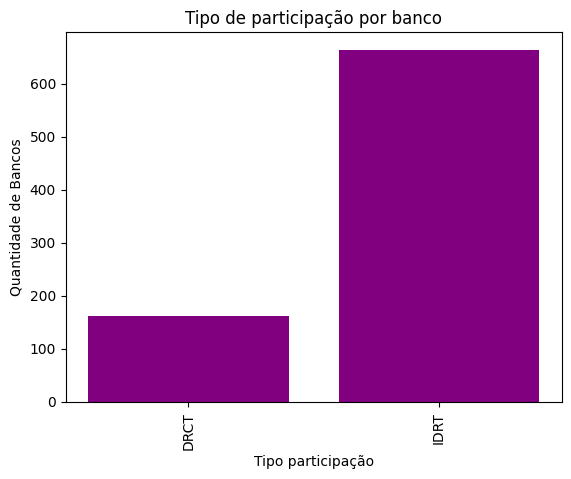

In [252]:
pix = carrega_bd("pix")
#bancos = bancos['inicio_operacao'] >= ('2023-01-01').format(datetime)
pix_agrupado = pix.groupby('tipo_participacao').count().reset_index()

#barras
plt.bar(pix_agrupado['tipo_participacao'], pix_agrupado['nome_reduzido'], color='purple')
plt.xticks(rotation=90)
plt.title("Tipo de participação por banco")
plt.xlabel("Tipo participação")
plt.ylabel("Quantidade de Bancos")

##### 5.2 Histograma

Text(0.5, 1.0, 'Histograma')

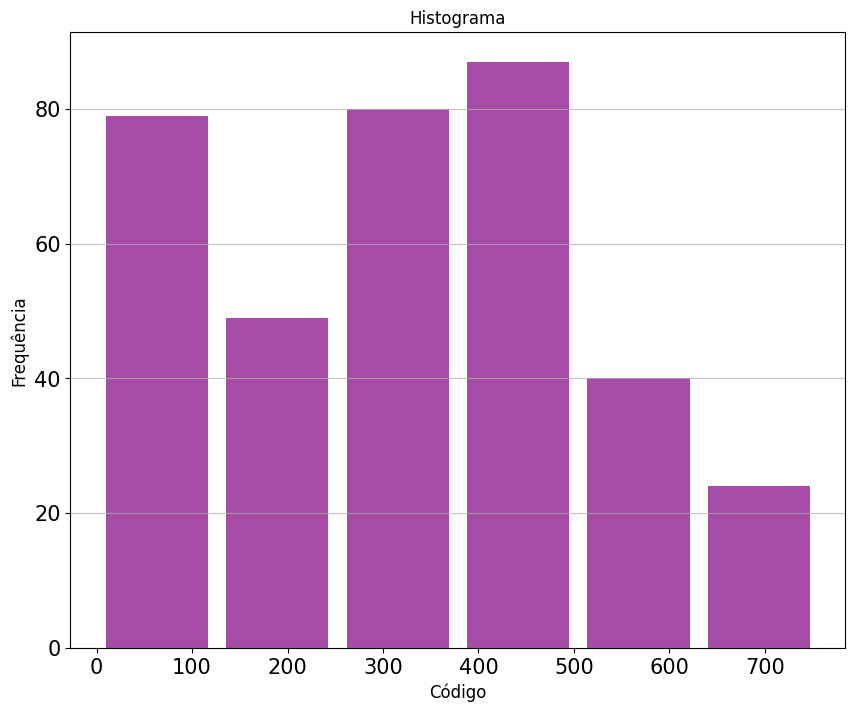

In [255]:
#histograma
bancos = carrega_bd("bancos")

plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(bancos['code'], bins=6, color='purple',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Código',fontsize=12)
plt.ylabel('Frequência',fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequência',fontsize=12)
plt.title('Histograma',fontsize=12)

##### 5.3 Distribuição

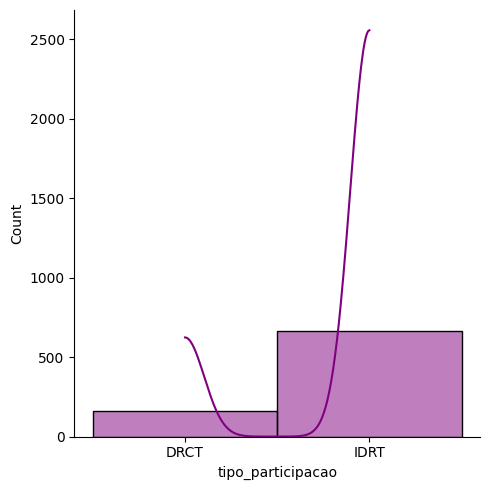

In [259]:
sns.displot(pix['tipo_participacao'], kde=True, color='purple')